# Log-file and interface-data processing

## Test cases

The following symbols are used to define the test cases in terms of dimensionless parameters:

symbol | meaning
:-----:|:-------
$\rho_l$, $\rho_g$ | liquid and gas phase density
$g$ | gravitational constant
$d_{b}$ | equivalent bubble diameter
$\sigma$ | surface tension coefficient
$\mu_l$, $\mu_g$ | dynamic liquid/gas viscosity
$\nu = \frac{\mu}{\rho}$ | kinematic liquid/gas viscosity

Four test cases are investigated:

Name | CB1         | CB2         | CB3         | CB4         |
:---:|:-----------:|:-----------:|:-----------:|:-----------:|
$Eo$ | 4,84574E-02 | 1,34604E-01 | 2,63824E-01 | 4,36117E-01 |
$Ga$ | 4,58580E+01 | 9,86708E+01 | 1,63448E+02 | 2,38285E+02 |

The Eotvos and Gallilei numbers are computed as

$$
  Eo = \frac{\rho_l g d_{b}^2}{\sigma}\quad \text{and}\quad Ga = \frac{\sqrt{gd_{b}^3}}{\nu_l}.
$$

The Morton number is set to a fixed value of

$$
  Mo = \frac{g \mu_l^4}{\rho_l \sigma^3} = 2.57288E-11,
$$

corresponding to tap water at $20^\circ C$. The ratios $\rho_l/\rho_g$ and $\mu_l/\mu_g$ are set to $100$. The density ratio is increased by a factor of ten compared to a typical gas/liquid system. To facilitate the simulation set-up and post-processing, $d_{b}$, $g$ and $\rho_l$ are set to unity. The remaining properties result from the above definitions. For completeness:

Name | CB1         | CB2         | CB3         | CB4         |
:---:|:-----------:|:-----------:|:-----------:|:-----------:|
$\mu_l$  | 2,18064E-02 | 1,01347E-02 | 6,11814E-03 | 4,19665E-03  | 
$\sigma$ | 2,06367E+01 | 7,42920E+00 | 3,79041E+00 | 2,29296E+00  |
$\mu_g$  | 2,18064E-04 | 1,01347E-04 | 6,11814E-05 | 4,19665E-05  | 
$\rho_g$ | 0,01        | 0,01        | 0,01        | 0,01         |



 
Time-dependent quantities are plotted over the gravitational time:

$$\tilde{t} = \frac{t}{\sqrt{d_b/g}}.$$

Since $d_b$ and $g$ are set to unity, the simulation time corresponds the (dimensionless) gravitational time.


## Log-file structure

The log-files contain integral bubble data like position and rise velocity.

The log-file columns (18 in total) are abbreviated as follows:

| index | log-name (unit)   | abbreviation |
|:--: | :---------------- | :----------- |
| 0   | Time (s)          | t            |
| 1   | Bubble velocity x-dir (m/s) | ub_x |
| 2   | Bubble velocity y-dir (m/s) | ub_y |
| 3   | Bubble velocity z-dir (m/s) | ub_z |
| 4   | Bubble volume (m^3) | vb |
| 5   | Centre of mass x (m) | cb_x |
| 6   | Centre of mass y (m) | cb_y |
| 7   | Centre of mass z (m) | cb_z |
| 8   | Max. dimensions db_x (m) | db_x |
| 9   | Max. dimensions db_y (m) | db_y |
| 10  | Max. dimensions db_z (m) | db_z |
| 11  | Remeshing Added | rm_add    |
| 12  | Remeshing Removed | rm_rem  |
| 13  | Remeshing Pyramids | rm_pyr |
| 14  | Pressure Jump (Pa) | p_jump |
| 15  | Local liquid velocity x-dir (m/s) | ul_x |
| 16  | Local liquid velocity y-dir (m/s) | ul_y |
| 17  | Local liquid velocity z-dir (m/s) | ul_z |

## Interface data structure

For each case, the interfacial mesh points, the velocity vector in each point, and the corresponding normal vector were saved. Snapshots are available for the iterations 1, 10, 50 and 100, and then for each 100th iteration until 100k iterations. In total, 1003 snapshots are available for each simulation. The naming of the snapshots follows the pattern *PointDataXXXXXX.dat*, where *XXXXXX* corresponds to the iteration. The columns in each snapshot file are named as follows:

| index | name (unit)   | abbreviation |
|:--: | :---------------- | :----------- |
| 0   | x-component of position vector (m) | x |
| 1   | y-component of position vector (m) | y |
| 2   | z-component of position vector (m) | z |
| 3   | x-component of velocity vector (m/s) | v_x |
| 4   | y-component of velocity vector (m/s) | v_y |
| 5   | z-component of velocity vector (m/s) | v_z |
| 6   | x-component of the unit normal vector (-) | n_x |
| 7   | x-component of the unit normal vector (-) | n_x |
| 8   | x-component of the unit normal vector (-) | n_x |

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from glob import glob
from tqdm import tqdm

%matplotlib inline
mpl.rcParams['figure.dpi'] = 160
rc('text', usetex=True)

cases = ["CB{:1d}".format(i) for i in range(1, 5)]
print("Case names : ", cases)

data_path = "../data/32_cells/"
output_path = "../output/"

output_cases = [output_path + case for case in cases]
for path in output_cases:
    !mkdir -p $path

Case names :  ['CB1', 'CB2', 'CB3', 'CB4']


## Log-file data

In [3]:
def read_fortran_formatting(path, first_row):
    with open(path, "r") as file:
        all_rows = file.readlines()
        all_rows_clean = []
        for row in all_rows[first_row:]:
            tokens = row.split(" ")
            all_rows_clean.append([float(x) for x in tokens if x not in ["", "\n"]])
        return all_rows_clean

In [4]:
columns = [
    "t",
    "ub_x", "ub_y", "ub_z",
    "vb",
    "cb_x", "cb_y", "cb_z",
    "db_x", "db_y", "db_z",
    "rm_add", "rm_rem", "rm_pyr",
    "p_jump",
    "ul_x", "ul_y", "ul_z"
]

log_files = {}
for case in cases:
    log_path = data_path + case + "/bub0000.log"
    print("Processing file {:s}".format(log_path))
    raw_data = read_fortran_formatting(log_path, first_row=5)
    log_files[case] = pd.DataFrame(np.asarray(raw_data), columns=columns)
    log_files[case].to_pickle(output_path + case + "/log_file.pkl")
    print(log_files[case][["t", "ub_x", "ub_y", "ub_z"]].describe())
    print("-"*100)

Processing file ../data/32_cells/CB1/bub0000.log
                   t           ub_x           ub_y           ub_z
count  100001.000000  100001.000000  100001.000000  100001.000000
mean        5.000000       1.444598       0.000092      -0.001117
std         2.886795       0.293890       0.000705       0.001692
min         0.000000       0.000000      -0.001221      -0.003499
25%         2.500000       1.509057      -0.000555      -0.002169
50%         5.000000       1.568653       0.000163      -0.001669
75%         7.500000       1.570529       0.000516      -0.000485
max        10.000000       1.572181       0.001377       0.002596
----------------------------------------------------------------------------------------------------
Processing file ../data/32_cells/CB2/bub0000.log
                   t           ub_x           ub_y           ub_z
count  100001.000000  100001.000000  100001.000000  100001.000000
mean        5.000000       2.162802       0.000538      -0.014422
std      

### Rise velocity vector

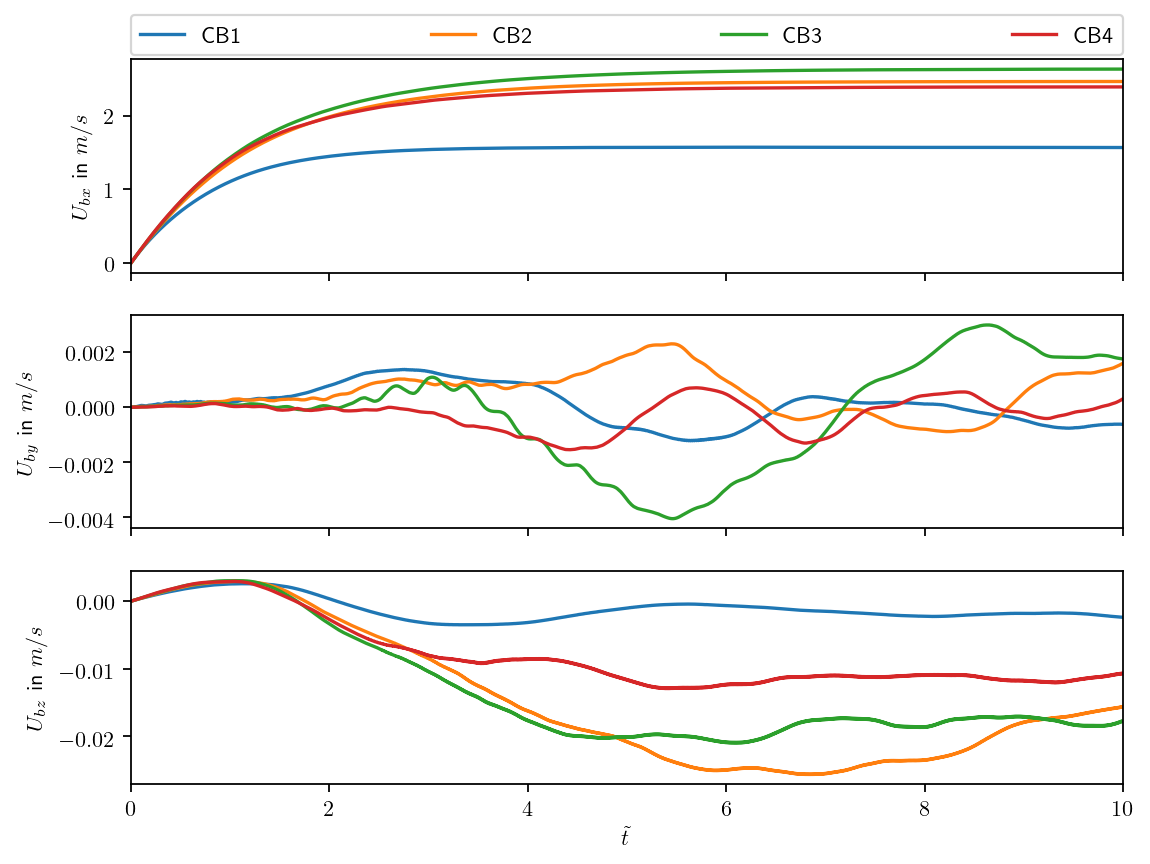

In [5]:
fig, axarr = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

for case in cases:
    data = log_files[case]
    axarr[0].plot(data.t, data.ub_x, label=case)
    axarr[0].set_ylabel(r"$U_{bx}$ in $m/s$")
    axarr[1].plot(data.t, data.ub_y, label=case)
    axarr[1].set_ylabel(r"$U_{by}$ in $m/s$")
    axarr[2].plot(data.t, data.ub_z, label=case)
    axarr[2].set_ylabel(r"$U_{bz}$ in $m/s$")

axarr[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", borderaxespad=0.,)
axarr[-1].set_xlabel(r"$\tilde{t}$")
axarr[-1].set_xlim(0.0, 10)
plt.show()

### Center of mass

- the position vector is normalized with the volume-equivalent bubble diameter; since the diameter is unity, both quantities are equal
- the initial position vector is subtracted

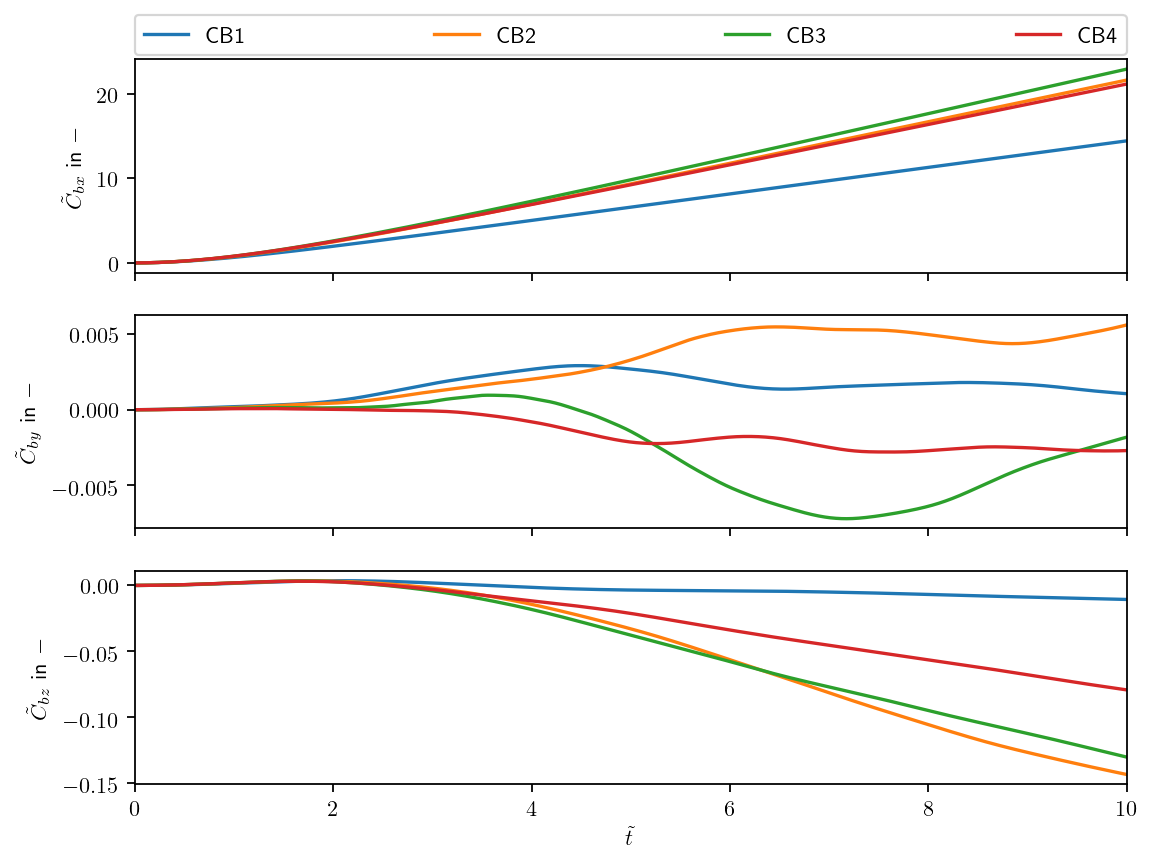

In [6]:
fig, axarr = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

for case in cases:
    data = log_files[case]
    axarr[0].plot(data.t, data.cb_x - data.cb_x[0], label=case)
    axarr[0].set_ylabel(r"$\tilde{C}_{bx}$ in $-$")
    axarr[1].plot(data.t, data.cb_y - data.cb_y[0], label=case)
    axarr[1].set_ylabel(r"$\tilde{C}_{by}$ in $-$")
    axarr[2].plot(data.t, data.cb_z - data.cb_z[0], label=case)
    axarr[2].set_ylabel(r"$\tilde{C}_{bz}$ in $-$")

axarr[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", borderaxespad=0.,)
axarr[-1].set_xlabel(r"$\tilde{t}$")
axarr[-1].set_xlim(0.0, 10)
plt.show()

### Bubble volume

- the volume loss is practically zero ($O(10^{-9})$)

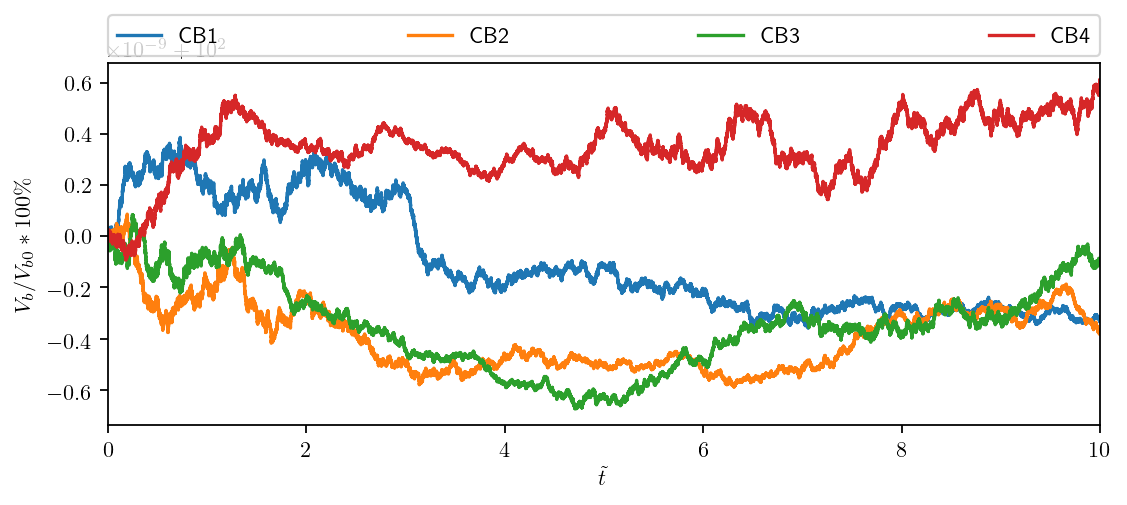

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

for case in cases:
    data = log_files[case]
    ax.plot(data.t, data.vb / data.vb[0] * 100, label=case)

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, mode="expand", borderaxespad=0.,)
ax.set_xlabel(r"$\tilde{t}$")
ax.set_xlim(0.0, 10)
ax.set_ylabel(r"$V_b / V_{b0} * 100\%$")
plt.show()

## Interface data

### Test of data pipeline

The raw 3D data (Cartesian) has to be processed as follows:

- conversion to 2D data given in terms of the polar coordinates $r$ and $\vartheta$
- projection of the velocity vector onto the interface to obtain normal and tangential contributions

**Note**

There is a discrepancy between the center of mass in the log file and the center of mass of the point cloud for iterations larger than roughly 10k. This effects comes presumably from the *moving window technique*. Therefore, the center of mass is estimated from the mean of all position vectors in the point cloud.

In [8]:
def load_snapshot(path):
    """Load snapshot from disk and convert to DataFrame."""
    columns = ["x", "y", "z", "v_x", "v_y", "v_z", "n_x", "n_y", "n_z"]
    raw_data = read_fortran_formatting(path, first_row=1)
    return pd.DataFrame(np.asarray(raw_data), columns=columns)


def cartesian3d_to_polar2d(pos_vec):
    """Converts Cartesian coordinates x, y, z to polar coordinates r and theta.
    
    The mean of all position vectors is subtracted to place the origin at (0, 0, 0).
    
    Parameters
    ----------
    pos_vec - array-like: shape (n_points, 3);
        columns are the x, y, and z coordinates
    
    Returns
    -------
    radius - array-like: radii of interface points
    theta - array-like: polar angle [0, pi]; 0 and pi
        correspond to the bubble's north and south pole, respectively
    
    """
    mean_pos = np.mean(pos_vec, axis=0)
    px = pos_vec[:, 0] - mean_pos[0]
    py = pos_vec[:, 1] - mean_pos[1]
    pz = pos_vec[:, 2] - mean_pos[2]
    radius = np.sqrt(np.square(px) + np.square(py) + np.square(pz))
    radius_yz = np.sqrt(np.square(py) + np.square(pz))
    theta = np.where(px >= 0, np.arcsin(radius_yz / radius), np.pi - np.arcsin(radius_yz / radius))
    return radius, theta


def project_velocity(velocity, normal, rise_velocity):
    """Project the velocity vector onto the normal and tangential unit vectors.
    
    Parameters
    ----------
    velocity - array-like: shape(n_points, 3); velocity vector at each point on
        the interface; given in a fixed frame of reference (not moving with the
        bubble's center of mass); given in a Cartesian coordinate system
    normal - array-like: shape (n_points, 3); unit normal vector at each point on
        the interface; given in Cartesian coordinates
    rise_velocity - array-like: shape (1, 3); the bubble's center of mass velocity
    
    Returns
    -------
    vel_norm - array-like: shape(n_points); velocity component in interface-normal direction
    vel_tan - array-like: shape(n_points); velocity component in tangential direction
    
    """
    vel_rel = velocity - rise_velocity
    vel_norm = np.sum(np.multiply(vel_rel, normal), axis=1)
    vel_tan = vel_rel - normal * np.repeat(vel_norm[:, np.newaxis], 3, axis=1)
    vel_mag = np.repeat(np.linalg.norm(vel_tan, axis=1)[:, np.newaxis], 3, axis=1)
    vel_tan = np.sum(np.multiply(vel_tan, vel_tan / vel_mag), axis=1)
    return vel_norm, vel_tan


def create_mask(field, cutoff):
    """Mask indices of a field if the values are above a cut-off value.
    
    Parameters
    ----------
    field - array-like: shape(n_points); typically normal component of velocity vector
    cutoff - float: if the magnitude of the field value in a point is above this value,
        the point is marked
        
    Returns
    -------
    mask - array-like: shape(n_points); mask value is one for points with values above
        the cutoff and zero otherwise
    """
    return np.where(np.absolute(field) > cutoff, 1, 0)


def compute_sector_average(fields, theta_index=0, n_sectors=100, mask=None):
    """Divide theta into sectors and average fields over the sectors.
    
    The polar angle theta \el [0, \pi] is divided into *n_sector* sectors.
    The entries in the theta array are then placed into the corresponding
    sector bin, and sector averages are computed for theta and all fields in
    the fields list.
    
    Parameters
    ----------
    fields - array-like: shape (n_points, n_fields); fields to average per sector
    theta_index - Integer: column of *fields* that holds the theta values
    n_sectors - Integer: number of sectors
    
    Returns
    -------
    fields_average - array-like: shape (n_sectors, n_fields); sector average of all fields
    
    """
    sector_width = np.pi / n_sectors
    sector_ubounds = np.arange(sector_width, np.pi + 0.1 * sector_width, sector_width)
    if mask is None:
        mask = np.zeros(fields.shape[0])
    theta = fields[:, theta_index]
    sort_ind = theta.argsort()
    fields_sorted = fields[sort_ind, :]
    theta = fields_sorted[:, theta_index]
    mask_sorted = mask[sort_ind]
    
    current_sector = 0
    n_rows = 0
    row_sum = np.zeros(fields.shape[1])
    fields_average = np.zeros((n_sectors, fields.shape[1]))
    for row, theta in enumerate(theta):
        if theta <= sector_ubounds[current_sector]:
            row_sum += fields_sorted[row, :] * (1.0 - mask_sorted[row])
            n_rows += 1 * (1.0 - mask_sorted[row])
        else:
            if n_rows > 0:
                fields_average[current_sector, :] = row_sum / n_rows
                n_rows = 1
                row_sum = fields_sorted[row, :]
            current_sector += 1
    if n_rows > 0:
        fields_average[current_sector, :] = row_sum / n_rows
    return fields_average

### Visualization of test data

Set *iteration* and *case* to visualize averaged tangential and normal velocity components in the cells below. The averaged radius as a funtion of $\vartheta$ is displayed, too. In contrast to the article, the velocity components are denoted with $v_n$ and $v_t$ for the normal and tangential components, respectively.

In [9]:
iteration = 1000
case = 3
test_file_path = data_path + cases[case] + "/PointData{:06d}.dat".format(iteration)
test_data = load_snapshot(test_file_path)
log_row = log_files[cases[case]].iloc[iteration]
test_data.head()

,x,y,z,v_x,v_y,v_z,n_x,n_y,n_z
0,4.690857,2.344101,2.843805,-0.073460,0.000007,0.006672,0.000270,0.007608,0.999971
1,4.703083,2.343954,2.843803,-0.072405,-0.000004,0.013024,0.000270,0.007608,0.999971
2,4.697099,2.354595,2.843723,-0.073138,0.000624,0.009798,0.000270,0.007608,0.999971
3,4.684875,2.354740,2.843576,-0.073969,0.000534,0.003410,-0.011919,0.014856,0.999819
4,4.678635,2.344248,2.843507,-0.073645,0.000019,0.000198,-0.024284,0.007901,0.999674


In [10]:
rad, theta = cartesian3d_to_polar2d(test_data[["x", "y", "z"]].values)
rise_vel = log_files[cases[case]].iloc[iteration][["ub_x", "ub_y", "ub_z"]].values
vel_norm, vel_tan = project_velocity(
    test_data[["v_x", "v_y", "v_z"]].values,
    test_data[["n_x", "n_y", "n_z"]].values,
    rise_vel
    )

for name, arr in [("radius", rad), ("theta", theta), ("normal velocity", vel_norm), ("tangential velocity", vel_tan)]:
    print("{:20s} mean/min/max: ".format(name), np.mean(arr), np.min(arr), np.max(arr))

radius               mean/min/max:  0.4999725882481094 0.4954233005575305 0.5043771040759077
theta                mean/min/max:  1.574258326200165 0.012261833982163432 3.138007717077875
normal velocity      mean/min/max:  -0.0007109216267423518 -0.17487835245312802 0.21778488517382322
tangential velocity  mean/min/max:  0.204845941223246 0.004002304285999908 0.29641585656334923


In [11]:
mask = create_mask(vel_norm, 0.5*np.linalg.norm(rise_vel))
print("Masked {:d} out of {:d} points ({:2.2f}%).".format(np.sum(mask), mask.shape[0], np.sum(mask)/mask.shape[0]*100))
av_profiles = compute_sector_average(np.array([theta, rad, vel_norm, vel_tan]).T, 0, 100, mask)

Masked 320 out of 28337 points (1.13%).


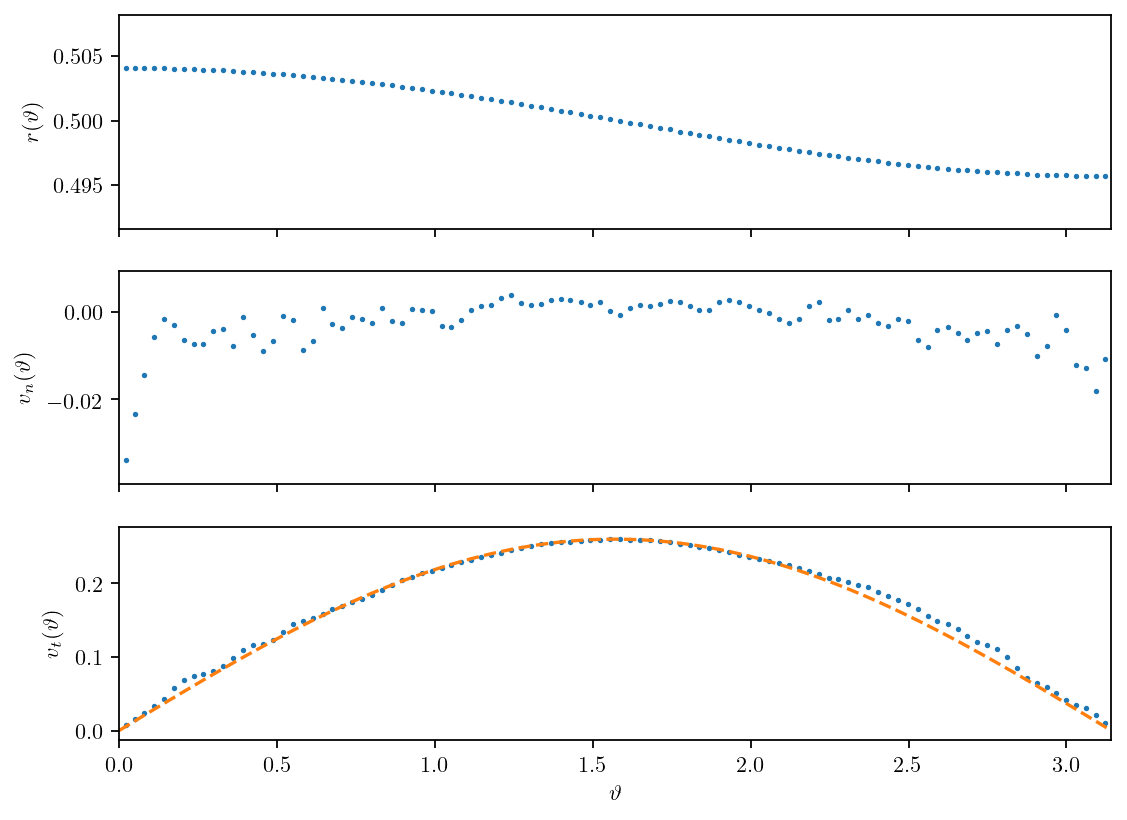

In [14]:
fig, axarr = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

theta_line = np.linspace(0.0, np.pi, 100)
vel_tan_sin = np.sin(theta_line) * np.max(av_profiles[:, 3])

axarr[0].scatter(av_profiles[:, 0], av_profiles[:, 1], s=2)
axarr[0].set_ylabel(r"$ r(\vartheta)$")
axarr[1].scatter(av_profiles[:, 0], av_profiles[:, 2], s=2)
axarr[1].set_ylabel(r"$ v_n(\vartheta)$")
axarr[2].scatter(av_profiles[:, 0], av_profiles[:, 3], s=2)
axarr[2].plot(theta_line, vel_tan_sin, ls="--", c="C1")
axarr[2].set_ylabel(r"$ v_t(\vartheta)$")
axarr[2].set_xlabel(r"$\vartheta$")

for ax in axarr:
    ax.set_xlim(0.0, np.pi)

plt.show()

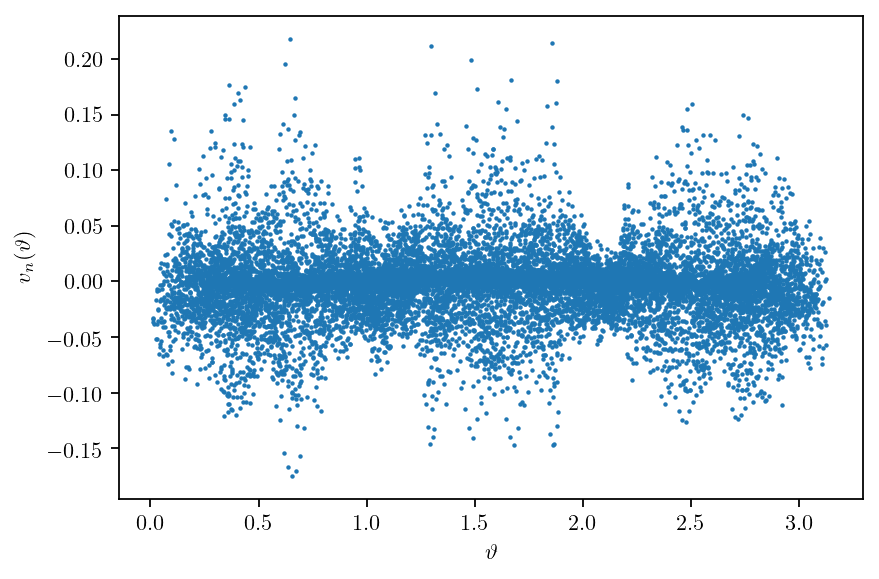

In [15]:
# the interpolated velocity vector for initial iterations is noisy
# the theoretical normal component is exactly zero
plt.scatter(theta, vel_norm, s=1)
plt.xlabel(r"$\vartheta$")
plt.ylabel(r"$v_n(\vartheta)$")
plt.savefig(output_path + "example_velocity_normal.pdf", bbox_inches="tight")

### Process interface data for all cases

In [14]:
for case in cases:
    data_files = glob(data_path + case + "/PointData*")
    iterations = sorted([int(file_name[-10:-4]) for file_name in data_files])
    data_list = []
    for iteration in tqdm(iterations):
        file_path = data_path + case + "/PointData{:06d}.dat".format(iteration)
        log_row = log_files[case].iloc[iteration]
        data = load_snapshot(file_path)
        rad, theta = cartesian3d_to_polar2d(data[["x", "y", "z"]].values)
        rise_vel = log_row[["ub_x", "ub_y", "ub_z"]].values
        # note that vel_theta here is actually the tangential velocity component and
        # corresponds only to the theta component for a spherical interface
        vel_norm, vel_theta = project_velocity(
            data[["v_x", "v_y", "v_z"]].values,
            data[["n_x", "n_y", "n_z"]].values,
            rise_vel
        )
        av_profiles = compute_sector_average(np.array([theta, rad, vel_norm, vel_theta]).T, 0, 100)
        df = pd.DataFrame(av_profiles, columns=["theta", "rad", "vel_norm", "vel_theta"])
        df["t"] = np.ones(av_profiles.shape[0]) * log_row.t
        data_list.append(df.copy())
    df_final = pd.concat(data_list)
    df_final.to_pickle(output_path + case + "/interface_data_processed.pkl")

100%|██████████| 1003/1003 [06:56<00:00,  1.93it/s]
